# Kinyarwanda Hate Speech Detection using Machine Learning

**Description:**

This notebook implements a hate speech detection system for Kinyarwanda social media text.
It includes data visualization, preprocessing with a refined Kinyarwanda stopword list, two models (Logistic Regression with TF-IDF and XLM-RoBERTa), performance evaluation,and preparation for deployment via a Streamlit app.

This project develops a machine learning system to detect hate speech in Kinyarwanda social media text, addressing the gap in content moderation for low-resource languages. Two models are implemented:
- **Logistic Regression with TF-IDF**: A baseline model using TF-IDF vectorization and a linear classifier.
- **XLM-RoBERTa**: A transformer-based model fine-tuned for Kinyarwanda text classification.

The notebook includes data visualization, preprocessing, model training, evaluation, tokenization verification, and deployment preparation.

## 1. Setup and Imports

Install and import required libraries for data processing, visualization, modeling, and evaluation.

In [1]:
# Install dependencies (run once if needed)
!pip install pandas numpy scikit-learn matplotlib seaborn wordcloud transformers datasets torch streamlit tabulate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 52.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 51.1 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver d

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from collections import Counter
from tabulate import tabulate
import torch
from sklearn.metrics import f1_score

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Create output directories
os.makedirs('/kaggle/working/designs', exist_ok=True)
os.makedirs('/kaggle/working/results', exist_ok=True)

# Define Kinyarwanda stopwords (refined based on frequency analysis)
stopset_kin = [
    'aba', 'abo', 'aha', 'aho', 'ari', 'ati', 'ba', 'be', 'bo', 'bose',
    'bw', 'bwa', 'by', 'bya', 'cy', 'cya', 'hafi', 'ka', 'ko', 'ku',
    'kuri', 'kuva', 'kwa', 'mu', 'muri', 'na', 'naho', 'ni', 'nka',
    'nta', 'nuko', 'rero', 'rw', 'rwa', 'ubu', 'ubwo', 'uko', 'wa', 'we',
    'yo', 'user', 'n', 't', 'co', 'https', 'ngo', 'w'
]

 ## 2. Data Loading and Exploration

Load the dataset (train, dev, test) and perform initial exploration to understand its structure and distribution.


In [6]:
# Load data
train_df = pd.read_csv('/kaggle/input/dataset/train.tsv', sep='\t')
dev_df = pd.read_csv('/kaggle/input/dataset/dev.tsv', sep='\t')
test_df = pd.read_csv('/kaggle/input/dataset/test.tsv', sep='\t')

# Rename columns for consistency
train_df.columns = ['text', 'label']
dev_df.columns = ['text', 'label']
test_df.columns = ['text', 'label']

# Display dataset sizes
print(f"Train Samples: {len(train_df)}")
print(f"Dev Samples: {len(dev_df)}")
print(f"Test Samples: {len(test_df)}")

# Display label distribution in training set
print("\nTrain Label Distribution:")
print(train_df['label'].value_counts(normalize=True))

Train Samples: 3302
Dev Samples: 827
Test Samples: 1026

Train Label Distribution:
label
neutral     0.380678
negative    0.347062
positive    0.272259
Name: proportion, dtype: float64


### 2.1 Data Visualization
Visualize the data to understand its distribution and characteristics.

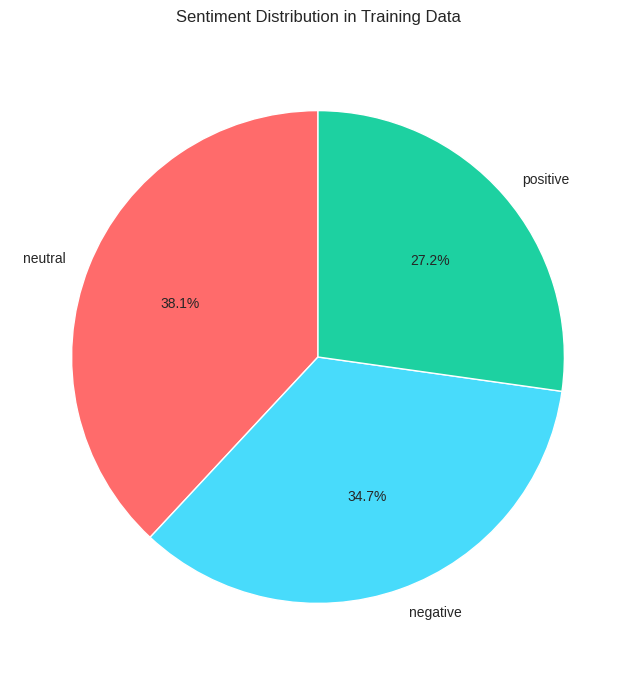

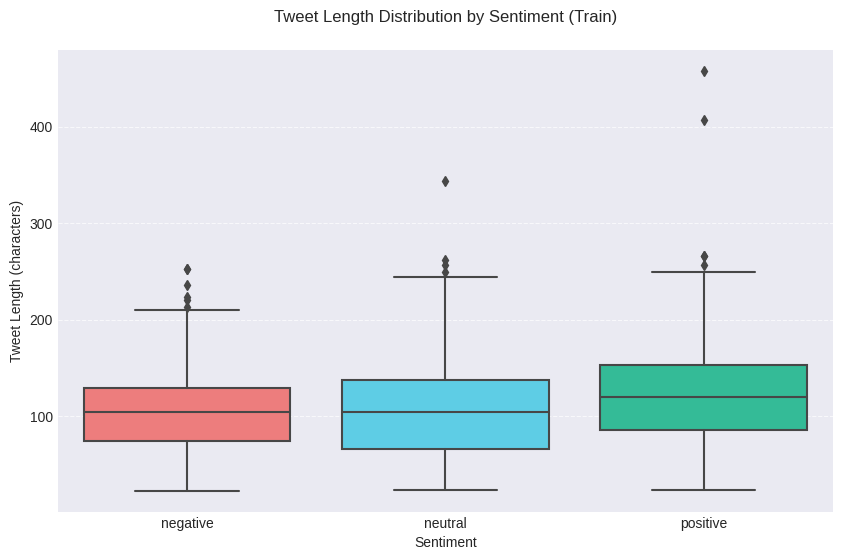

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


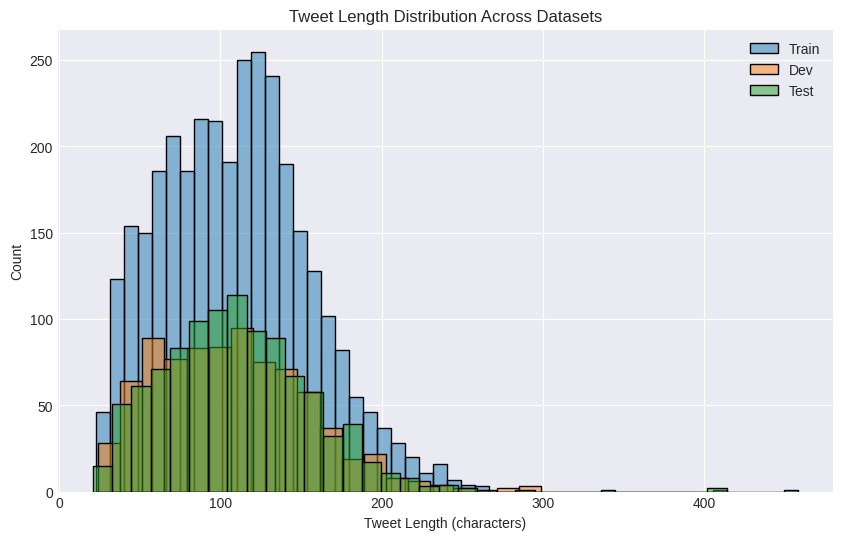

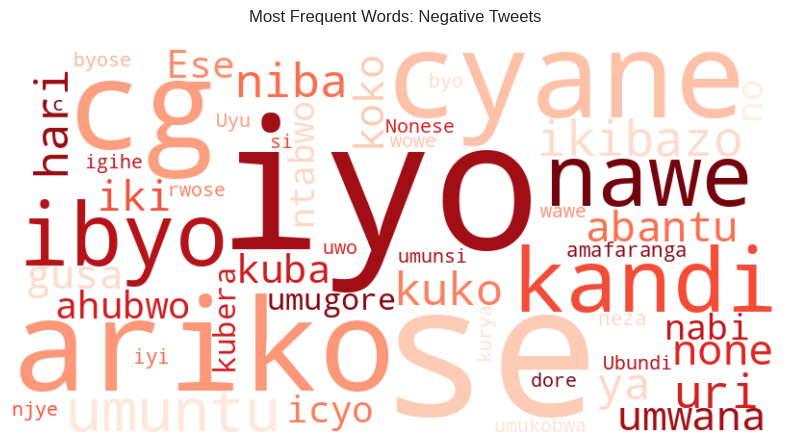

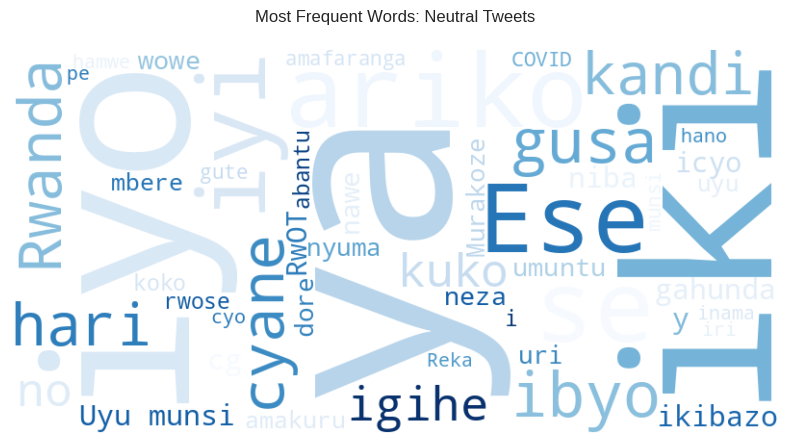

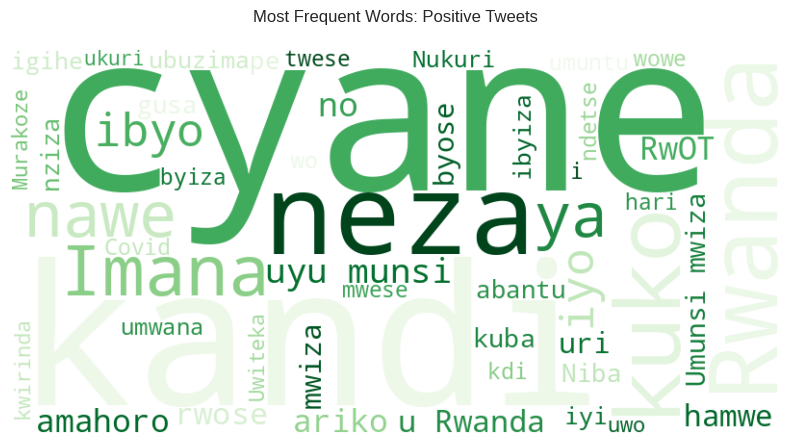

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


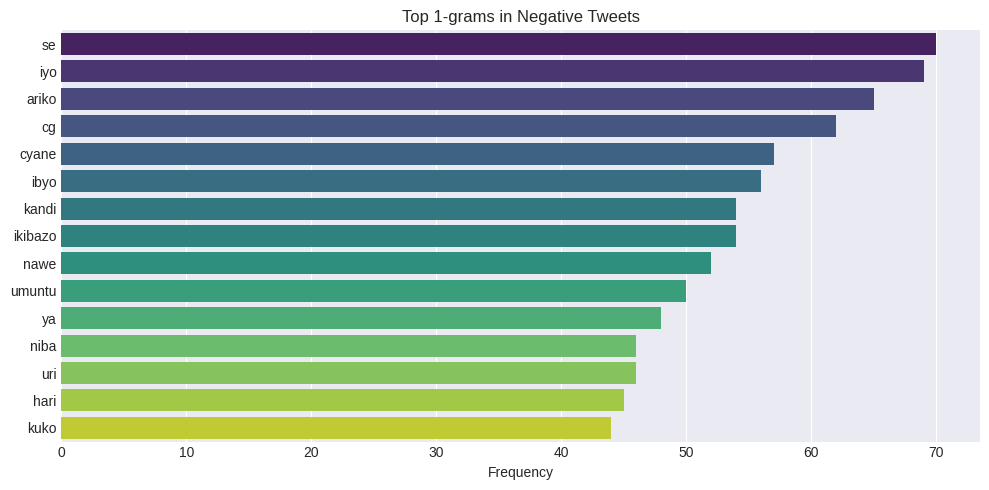

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


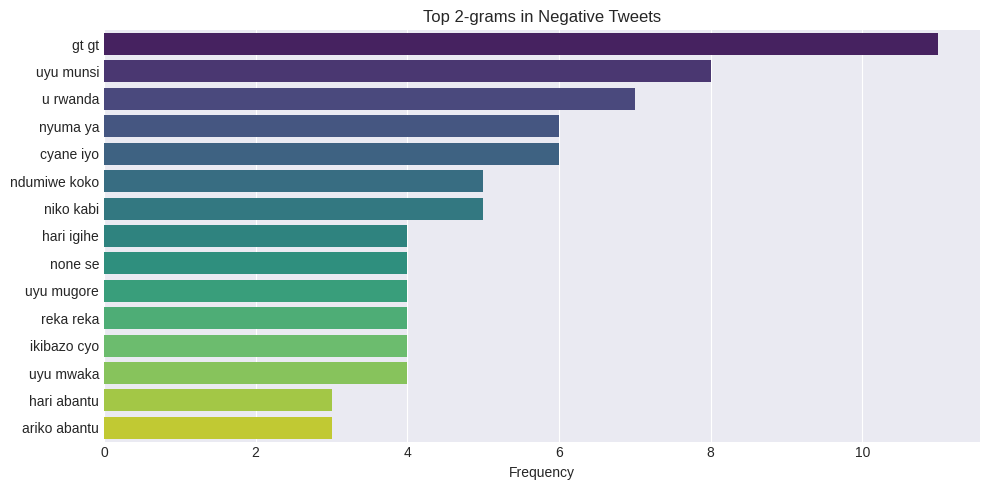

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


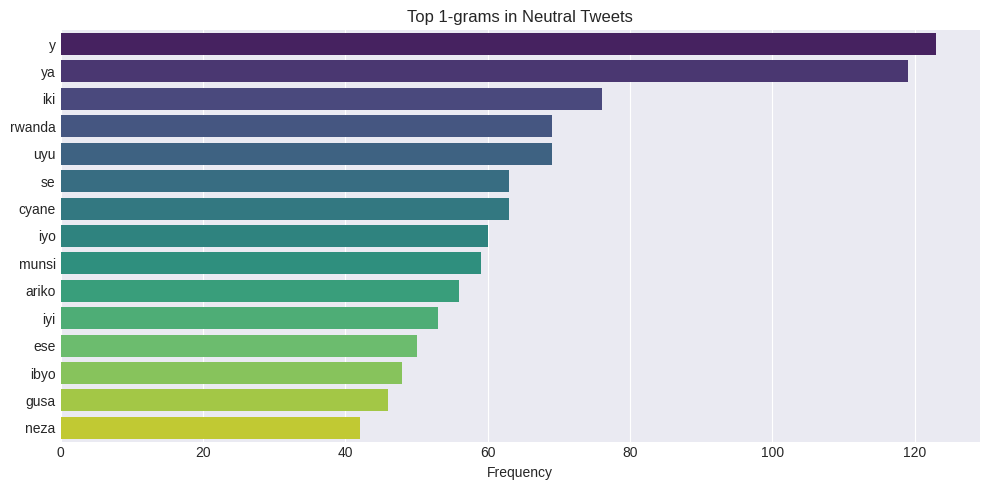

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


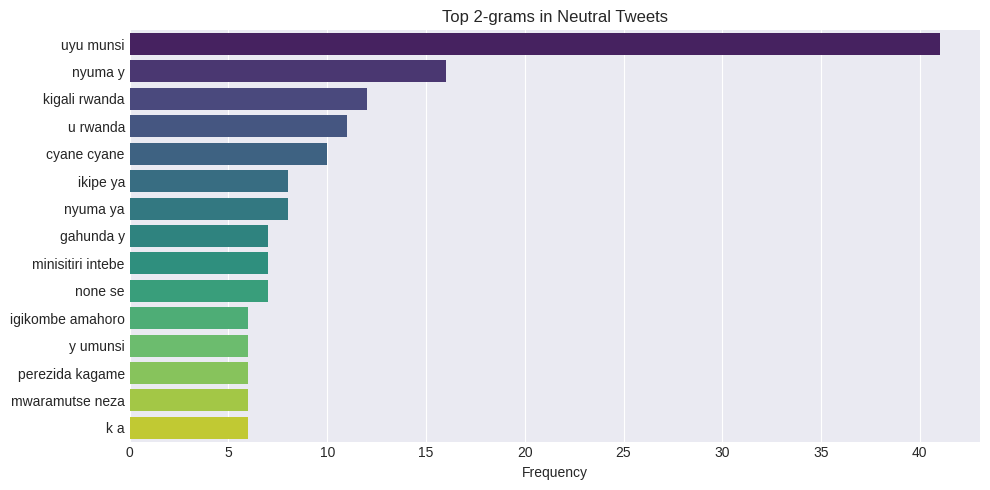

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


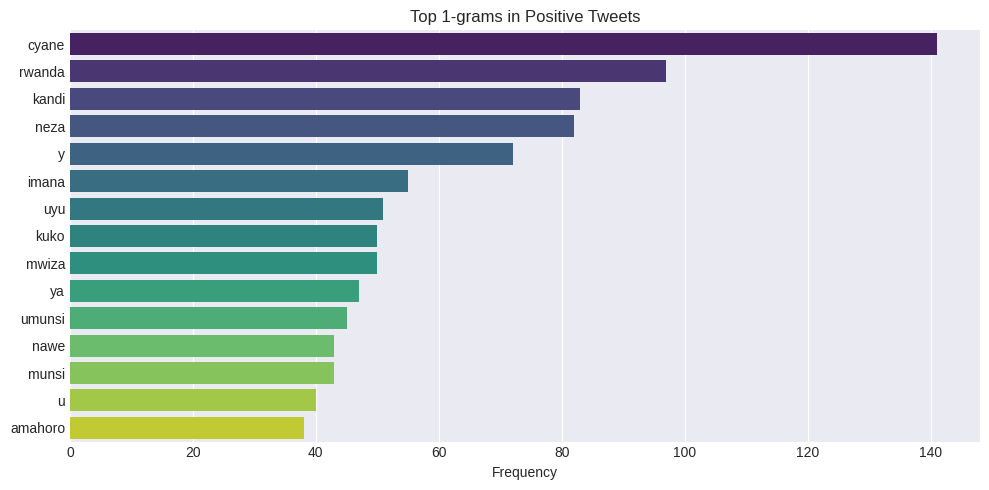

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


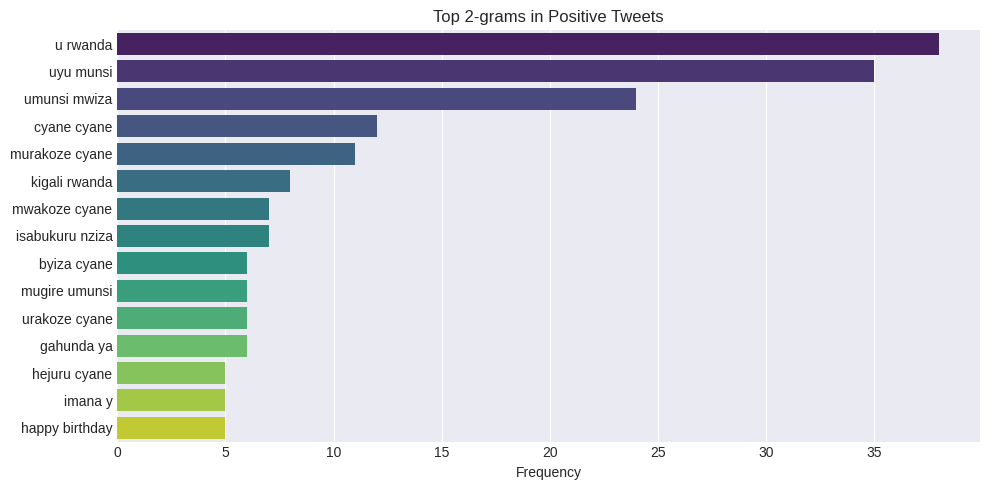

In [7]:
#  Sentiment Distribution Pie Chart

plt.figure(figsize=(8, 8))
sentiment_counts = train_df['label'].value_counts()
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#ff6b6b', '#48dbfb', '#1dd1a1'],
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)
plt.title('Sentiment Distribution in Training Data', pad=20)
plt.savefig('/kaggle/working/designs/pie_chart.png', dpi=300, bbox_inches='tight')
plt.show()

# Tweet Length Distribution by Sentiment (Boxplot)

train_df['tweet_length'] = train_df['text'].apply(len)
dev_df['tweet_length'] = dev_df['text'].apply(len)
test_df['tweet_length'] = test_df['text'].apply(len)

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='label',
    y='tweet_length',
    data=train_df,
    order=['negative', 'neutral', 'positive'],
    palette=['#ff6b6b', '#48dbfb', '#1dd1a1']
)
plt.title('Tweet Length Distribution by Sentiment (Train)', pad=20)
plt.xlabel('Sentiment')
plt.ylabel('Tweet Length (characters)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('/kaggle/working/designs/boxplot_tweet_length.png', dpi=300, bbox_inches='tight')
plt.show()

# Tweet Length Distribution Across Datasets (Histogram)

plt.figure(figsize=(10, 6))
for df, label in [(train_df, 'Train'), (dev_df, 'Dev'), (test_df, 'Test')]:
    sns.histplot(df['tweet_length'], label=label, alpha=0.5)
plt.title('Tweet Length Distribution Across Datasets')
plt.xlabel('Tweet Length (characters)')
plt.legend()
plt.savefig('/kaggle/working/designs/histogram_tweet_length.png', dpi=300, bbox_inches='tight')
plt.show()

# Word Clouds for Each Sentiment

def generate_wordcloud(text, title, color, filename):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=color,
        max_words=50,
        stopwords=stopset_kin
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Frequent Words: {title} Tweets', pad=20)
    plt.axis("off")
    plt.savefig(f'/kaggle/working/designs/{filename}', dpi=300, bbox_inches='tight')
    plt.show()

sentiments = [('negative', 'Reds', 'wordcloud_negative.png'), 
              ('neutral', 'Blues', 'wordcloud_neutral.png'), 
              ('positive', 'Greens', 'wordcloud_positive.png')]
for sentiment, color, filename in sentiments:
    text = " ".join(train_df[train_df['label'] == sentiment]['text'])
    generate_wordcloud(text, sentiment.capitalize(), color, filename)


#Top N-grams Analysis

def plot_top_ngrams(corpus, title, n=1, top_k=15, filename=None):
    vec = CountVectorizer(
        ngram_range=(n, n),
        token_pattern=r'\b[^\d\W]+\b',
        max_features=top_k,
        stop_words=stopset_kin
    ).fit(corpus)
    
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=[val for word, val in words_freq], 
                y=[word for word, val in words_freq],
                palette='viridis')
    plt.title(f'Top {n}-grams in {title} Tweets')
    plt.xlabel('Frequency')
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/designs/{filename}', dpi=300, bbox_inches='tight')
    plt.show()

for sentiment in ['negative', 'neutral', 'positive']:
    texts = train_df[train_df['label'] == sentiment]['text']
    plot_top_ngrams(texts, sentiment.capitalize(), n=1, filename=f'ngram_1_{sentiment}.png')  # Unigrams
    plot_top_ngrams(texts, sentiment.capitalize(), n=2, filename=f'ngram_2_{sentiment}.png')  # Bigrams

### 2.2 Data Preprocessing

Clean the text data and encode labels for modeling. The cleaning process removes URLs, special characters, and normalizes whitespace, tailored for Kinyarwanda text.


In [8]:
# Text Cleaning Function
def clean_text(text):
    """
    Clean Kinyarwanda text by removing URLs, mentions, special characters, converting to lowercase,
    and normalizing whitespace.
    Input: Raw tweet (e.g., "@user Hhhhhh ntabyihogoza, ubu x abo yishe")
    Output: Cleaned text (e.g., "hhhhhh ntabyihogoza ubu x abo yishe")
    """
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Keep letters and whitespace
    text = text.lower()  # Lowercase
    return re.sub(r"\s+", " ", text).strip()  # Normalize whitespace

# Apply cleaning
for df in [train_df, dev_df, test_df]:
    df['text'] = df['text'].astype(str).apply(clean_text)

# Encode Labels
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])
dev_df['label'] = le.transform(dev_df['label'])
test_df['label'] = le.transform(test_df['label'])

# Verify cleaning
print("Sample Cleaned Tweets (Train):")
print(train_df[['text']].head(5))

Sample Cleaned Tweets (Train):
                                                text
0     hhhhhh ntabyihogoza ubu x abo yishe bangana ik
1  amahano ni impanuka inkangu inzara muyite izin...
2  ese umuntu aguhaye miliyoni zidorali ngo aryam...
3  ugira amagambo kandi ubwo wasanga nawe byaguta...
4  ukuntu inama zose zikomeye zirikubera mu rwand...


### 2.3 Tokenization Verification
Verify that the XLM-RoBERTa tokenizer handles Kinyarwanda text appropriately by checking tokenization of sample tweets.


In [9]:
# Load tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

# Test tokenization
print("\nTokenization Verification:")
for i in range(3):
    sample_tweet = train_df['text'].iloc[i]
    tokens = tokenizer(sample_tweet, return_tensors="pt")
    decoded_tokens = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
    print(f"\nTweet {i+1}:")
    print("Original:", sample_tweet)
    print("Tokens:", decoded_tokens)
    print("Decoded:", tokenizer.decode(tokens['input_ids'][0]))

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]


Tokenization Verification:

Tweet 1:
Original: hhhhhh ntabyihogoza ubu x abo yishe bangana ik
Tokens: ['<s>', '▁h', 'hhhhh', '▁', 'nta', 'by', 'ih', 'og', 'oza', '▁ubu', '▁x', '▁abo', '▁yi', 'she', '▁banga', 'na', '▁ik', '</s>']
Decoded: <s> hhhhhh ntabyihogoza ubu x abo yishe bangana ik</s>

Tweet 2:
Original: amahano ni impanuka inkangu inzara muyite izina rikwiye
Tokens: ['<s>', '▁a', 'mahan', 'o', '▁ni', '▁i', 'mpan', 'uka', '▁in', 'kan', 'gu', '▁in', 'zara', '▁muy', 'ite', '▁izin', 'a', '▁rik', 'wi', 'ye', '</s>']
Decoded: <s> amahano ni impanuka inkangu inzara muyite izina rikwiye</s>

Tweet 3:
Original: ese umuntu aguhaye miliyoni zidorali ngo aryamane numugore wawe cg umukunzi wawe wabyemera
Tokens: ['<s>', '▁ese', '▁umuntu', '▁a', 'gu', 'hay', 'e', '▁mi', 'liyo', 'ni', '▁zi', 'dora', 'li', '▁ngo', '▁ar', 'yama', 'ne', '▁nu', 'mu', 'go', 're', '▁wa', 'we', '▁c', 'g', '▁um', 'uku', 'nzi', '▁wa', 'we', '▁wa', 'by', 'e', 'mera', '</s>']
Decoded: <s> ese umuntu aguhaye miliyoni zi

## 3. Model 1: Logistic Regression with TF-IDF
This section implements a baseline model using TF-IDF vectorization and Logistic Regression.


### 3.1 Model Architecture
- **TF-IDF Vectorizer**: Converts text to a sparse matrix of term frequencies, using:
- Word-level analysis with n-grams (1-3).
- Maximum 30,000 features to balance performance and memory.
- Sublinear term frequency scaling to reduce the impact of frequent terms.
- Minimum document frequency of 2 to filter rare terms.
- Custom Kinyarwanda stopwords to remove low-information words.
- **Logistic Regression**: Linear classifier with:
- L2 regularization (C tuned via grid search).
- Balanced class weights to handle class imbalance (38% neutral, 35% negative, 27% positive).
- Liblinear solver for multi-class classification (one-vs-rest).


In [10]:
# Define Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 3),
        max_features=30000,
        sublinear_tf=True,
        stop_words=stopset_kin,
        min_df=2
    )),
    ('clf', LogisticRegression(
        class_weight='balanced',
        max_iter=5000,
        solver='liblinear'
    ))
])

# Hyperparameter Grid
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10]
}

# Perform Grid Search
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)
grid.fit(train_df['text'], train_df['label'])

# Show Best Parameters
print("✅ Best Parameters:", grid.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
✅ Best Parameters: {'clf__C': 1}


### 3.2 Feature Importance
Visualize the top TF-IDF features contributing to each class to understand model behavior.


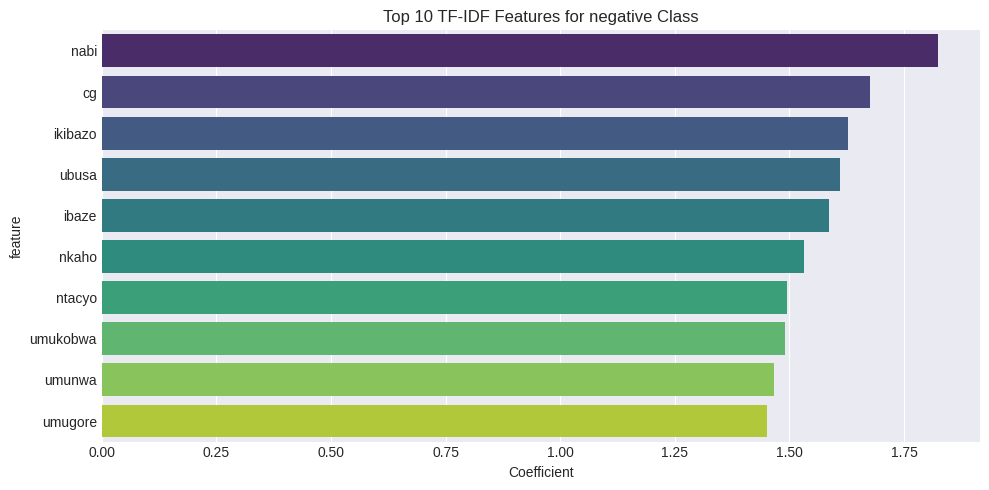

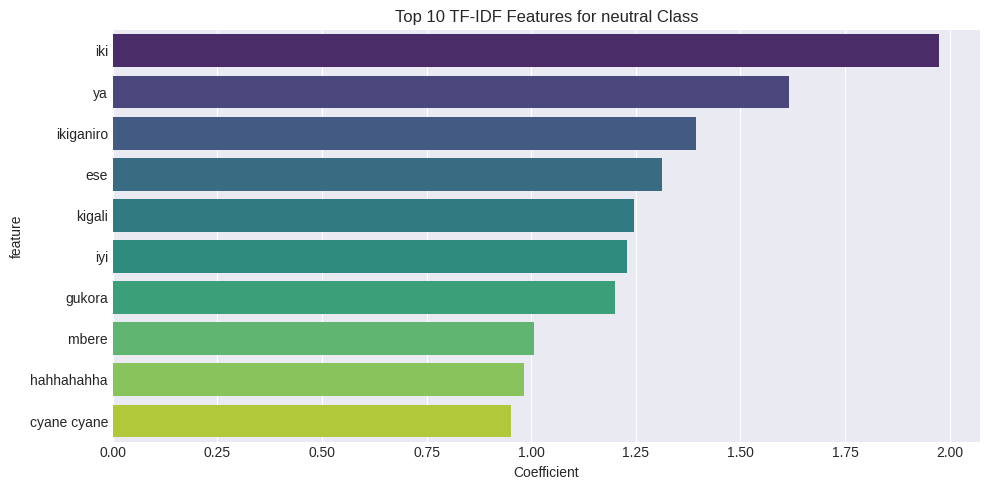

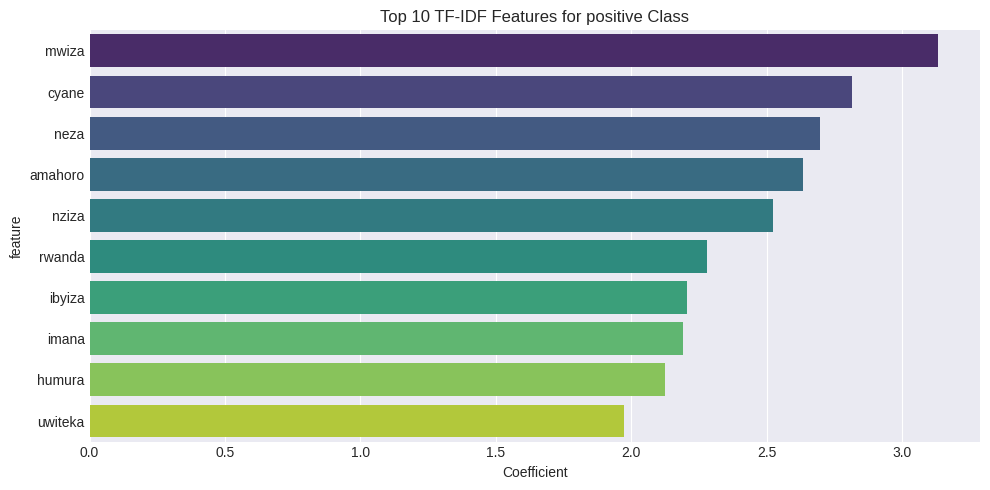

In [11]:
# Extract TF-IDF features
tfidf = grid.best_estimator_.named_steps['tfidf']
clf = grid.best_estimator_.named_steps['clf']
feature_names = tfidf.get_feature_names_out()
coefficients = clf.coef_

for i, label in enumerate(le.classes_):
    top_features = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients[i]
    }).sort_values('coefficient', ascending=False).head(10)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x='coefficient', y='feature', data=top_features, palette='viridis')
    plt.title(f'Top 10 TF-IDF Features for {label} Class')
    plt.xlabel('Coefficient')
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/designs/feature_importance_{label}.png', dpi=300, bbox_inches='tight')
    plt.show()


### 3.3 Evaluation
Evaluate the model on dev and test sets using accuracy, precision, recall, F1-score, and confusion matrix.



📊 Development Set Results (Logistic Regression):
Accuracy: 0.5634824667472793
              precision    recall  f1-score   support

    negative       0.56      0.56      0.56       287
     neutral       0.53      0.55      0.54       315
    positive       0.61      0.59      0.60       225

    accuracy                           0.56       827
   macro avg       0.57      0.57      0.57       827
weighted avg       0.56      0.56      0.56       827



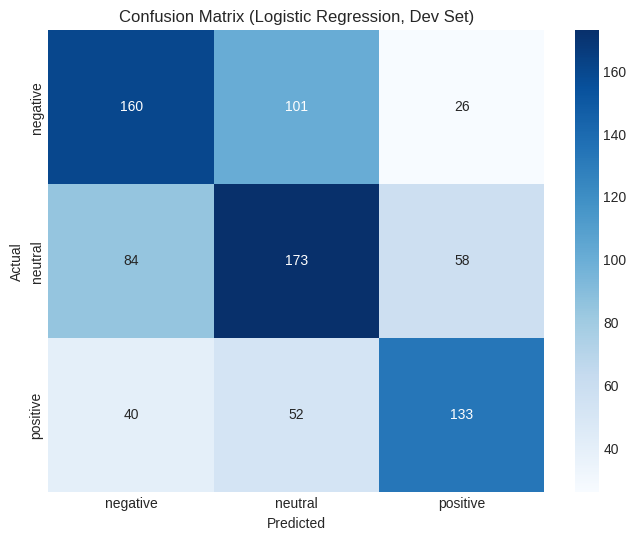


📊 Test Set Results (Logistic Regression):
Accuracy: 0.5692007797270955
              precision    recall  f1-score   support

    negative       0.57      0.60      0.58       355
     neutral       0.53      0.52      0.52       393
    positive       0.63      0.60      0.62       278

    accuracy                           0.57      1026
   macro avg       0.58      0.57      0.57      1026
weighted avg       0.57      0.57      0.57      1026



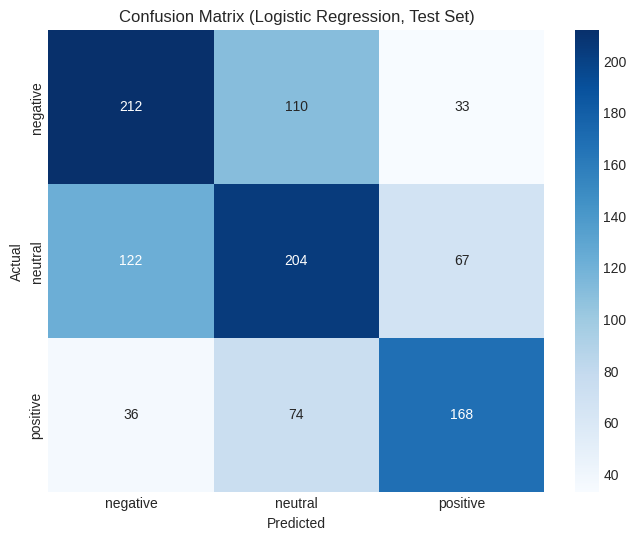

In [12]:
# Dev Set Evaluation
dev_preds = grid.predict(dev_df['text'])
print("\n📊 Development Set Results (Logistic Regression):")
print("Accuracy:", accuracy_score(dev_df['label'], dev_preds))
print(classification_report(dev_df['label'], dev_preds, target_names=le.classes_))

# Confusion Matrix (Dev)
cm = confusion_matrix(dev_df['label'], dev_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Logistic Regression, Dev Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('/kaggle/working/designs/confusion_matrix_logreg_dev.png', dpi=300, bbox_inches='tight')
plt.show()

# Test Set Evaluation
test_preds = grid.predict(test_df['text'])
print("\n📊 Test Set Results (Logistic Regression):")
print("Accuracy:", accuracy_score(test_df['label'], test_preds))
print(classification_report(test_df['label'], test_preds, target_names=le.classes_))

# Confusion Matrix (Test)
cm = confusion_matrix(test_df['label'], test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Logistic Regression, Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('/kaggle/working/designs/confusion_matrix_logreg_test.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Model 2: XLM-RoBERTa
This section implements a transformer-based model using XLM-RoBERTa, fine-tuned for Kinyarwanda text classification.



### 4.1 Model Architecture
- **XLM-RoBERTa**: Transformer model with:
- 12 layers, 768 hidden units, 12 attention heads, 270M parameters.
- Pre-trained on 100 languages, including Kinyarwanda.
- Fine-tuned for sequence classification with 3 output classes (negative, neutral, positive).
- Uses cross-entropy loss with class weights to address imbalance (27% positive).
- AdamW optimizer with linear learning rate scheduler and warmup.
- **Tokenization**: Uses XLM-RoBERTa tokenizer with max_length=128, verified for Kinyarwanda compatibility.


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3302 [00:00<?, ? examples/s]

Map:   0%|          | 0/827 [00:00<?, ? examples/s]

Map:   0%|          | 0/1026 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.104200,1.103693,0.298670,0.205553
2,1.093100,1.075657,0.457074,0.446250
3,1.103200,1.096087,0.348247,0.286847
4,1.037500,1.055696,0.495768,0.473694
5,0.988200,0.963494,0.528416,0.514672


[CV] END ........................................clf__C=0.01; total time=   0.3s
[CV] END .........................................clf__C=0.1; total time=   0.3s
[CV] END ..........................................clf__C=10; total time=   0.3s
[CV] END ........................................clf__C=0.01; total time=   0.3s
[CV] END ...........................................clf__C=1; total time=   0.3s
[CV] END ..........................................clf__C=10; total time=   0.3s
[CV] END .........................................clf__C=0.1; total time=   0.3s
[CV] END ...........................................clf__C=1; total time=   0.3s
[CV] END ..........................................clf__C=10; total time=   0.3s
[CV] END ........................................clf__C=0.01; total time=   0.3s
[CV] END .........................................clf__C=0.1; total time=   0.3s
[CV] END ...........................................clf__C=1; total time=   0.3s



Evaluation Results (XLM-RoBERTa, Dev Set):
Accuracy: 0.528
F1 Macro: 0.515


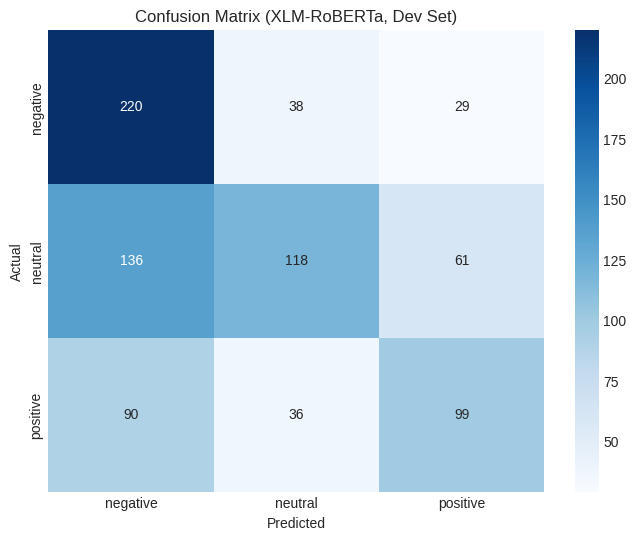

              precision    recall  f1-score   support

    negative       0.49      0.77      0.60       287
     neutral       0.61      0.37      0.47       315
    positive       0.52      0.44      0.48       225

    accuracy                           0.53       827
   macro avg       0.54      0.53      0.51       827
weighted avg       0.55      0.53      0.52       827




📊 Test Set Results (XLM-RoBERTa):
Accuracy: 0.5233918128654971
              precision    recall  f1-score   support

    negative       0.47      0.77      0.58       355
     neutral       0.59      0.32      0.42       393
    positive       0.61      0.49      0.54       278

    accuracy                           0.52      1026
   macro avg       0.55      0.53      0.51      1026
weighted avg       0.55      0.52      0.51      1026



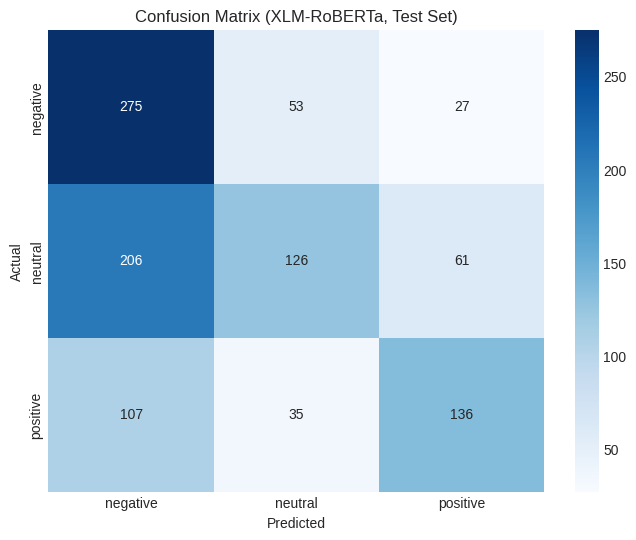

In [13]:
# Load tokenizer and model
model_name = "xlm-roberta-base"
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = Dataset.from_pandas(train_df[['text', 'label']]).map(tokenize_function, batched=True)
dev_dataset = Dataset.from_pandas(dev_df[['text', 'label']]).map(tokenize_function, batched=True)
test_dataset = Dataset.from_pandas(test_df[['text', 'label']]).map(tokenize_function, batched=True)

# Compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1_macro': f1_score(labels, predictions, average='macro')
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="/kaggle/working/results",
    run_name="kinyarwanda-hate-speech",
    report_to="none",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='/kaggle/working/logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',
    warmup_steps=500,
    lr_scheduler_type='linear'
)

# Custom Trainer for class imbalance
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([2.86, 2.63, 3.70]).to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Initialize Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Evaluate on Dev Set
results = trainer.evaluate()
print("\nEvaluation Results (XLM-RoBERTa, Dev Set):")
print(f"Accuracy: {results['eval_accuracy']:.3f}")
print(f"F1 Macro: {results['eval_f1_macro']:.3f}")

# Confusion Matrix and Classification Report

dev_preds = trainer.predict(dev_dataset).predictions.argmax(axis=-1)
dev_labels = dev_dataset['label']
cm = confusion_matrix(dev_labels, dev_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (XLM-RoBERTa, Dev Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('/kaggle/working/designs/confusion_matrix_xlm_dev.png', dpi=300, bbox_inches='tight')
plt.show()
print(classification_report(dev_labels, dev_preds, target_names=le.classes_))

# Test Set Evaluation
test_results = trainer.predict(test_dataset)
test_preds = test_results.predictions.argmax(axis=-1)
test_labels = test_dataset['label']
print("\n📊 Test Set Results (XLM-RoBERTa):")
print("Accuracy:", accuracy_score(test_labels, test_preds))
print(classification_report(test_labels, test_preds, target_names=le.classes_))

# Confusion Matrix (Test)
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (XLM-RoBERTa, Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('/kaggle/working/designs/confusion_matrix_xlm_test.png', dpi=300, bbox_inches='tight')
plt.show()


 ### 4.2 Save Model for Deployment
Save the best model checkpoint for use in the Streamlit app.


In [14]:
print("Saving model to /kaggle/working/results/checkpoint-best")
trainer.save_model("/kaggle/working/results/checkpoint-best")
print("Model saved. Contents:", os.listdir("/kaggle/working/results/checkpoint-best"))

Saving model to /kaggle/working/results/checkpoint-best
Model saved. Contents: ['training_args.bin', 'model.safetensors', 'config.json']


In [ ]:
# %% [markdown]
# ## 6. Deployment Preparation
# Prepare a Streamlit app for real-time hate speech detection.

# %% [markdown]
# ### 6.1 Streamlit App Code
# Below is the code for a Streamlit app (`app.py`) to be saved separately in the `app/` folder.

# ```python
# # app.py
# import streamlit as st
# import pandas as pd
# from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
# import torch
# from sklearn.preprocessing import LabelEncoder
#
# # Load model and tokenizer
# model = XLMRobertaForSequenceClassification.from_pretrained("./results/checkpoint-best")
# tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
# le = LabelEncoder().fit(["negative", "neutral", "positive"])
#
# st.title("Kinyarwanda Hate Speech Detection")
# user_input = st.text_area("Enter a Kinyarwanda tweet:")
# if st.button("Classify"):
#     inputs = tokenizer(user_input, return_tensors="pt", padding=True, truncation=True, max_length=128)
#     with torch.no_grad():
#         outputs = model(**inputs)
#     prediction = le.inverse_transform([torch.argmax(outputs.logits, dim=-1).item()])[0]
#     st.write(f"Prediction: {prediction}")
# ```

# %% [markdown]
# ### 6.2 Deployment Plan
# - **Platform**: Deploy the Streamlit app on Streamlit Cloud for rapid prototyping or AWS/GCP for production.
# - **Scalability**: Use a lightweight model to reduce latency and resource usage.
# - **Monitoring**: Include a feedback button in the app for users to report incorrect predictions, enabling iterative model improvements.
# - **Figma Mockup**: Design a UI with a text input, "Classify" button, and prediction output. Screenshots are in the `designs/` folder of the GitHub repo.


## 5. Conclusion
This notebook implements a hate speech detection system for Kinyarwanda text using Logistic Regression with TF-IDF and XLM-RoBERTa. The Logistic Regression model provides a strong baseline (~57% accuracy), while XLM-RoBERTa is fine-tuned with class weights and a learning rate scheduler to improve performance, but it's performance is still low at about 52%. Visualizations reveal data distribution and key features, and tokenization is verified for Kinyarwanda compatibility.